In [97]:
import pandas as pd
import numpy as np
import os
import re
import json
import urllib.request
from urllib.parse import quote_plus
from datetime import datetime,timedelta
from copy import copy
from time import sleep
import matplotlib as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from copy import copy
from gnews import GNews


import selenium
from bs4 import BeautifulSoup as bs




In [71]:
class Movie:
    def __init__(self, title, actors, directors,release_date, gross_income, query):
        self.title = title
        self.actors = actors
        self.directors = directors
        self.release_date = release_date
        self.gross_income = gross_income
        self.query = query
        
    def get_df(self):
        print("fetching articles")
        self.fetch_articles()
        print(f"{self.df.shape[0]} Articles found")

        print("getting text")
        self.get_full_text()
        print(f"{self.df.shape[0]} Articles with full text")

        print("categorizing")
        self.categorize_articles()
        print(f"{self.df.shape[0]} Articles categorized")
    
    def fetch_articles(self):
        month_before = self.release_date - timedelta(days=30)
        month_after = self.release_date + timedelta(days=30)
        sd = (month_before.year,month_before.month,month_before.day)
        rd = (self.release_date.year,self.release_date.month,self.release_date.day)
        ed = (month_after.year,month_after.month,month_after.day)

        self.google_news = GNews(language='en', country='US', start_date=sd, end_date=ed, max_results=500)
        
        gnews1 = GNews(language='en', country='US', start_date=sd, end_date=rd, max_results=500)
        gnews2 = GNews(language='en', country='US', start_date=rd, end_date=ed, max_results=500)

        self.df = self.fetch_articles_for_keyword(gnews1,self.title)
        self.df = self.df.append(self.fetch_articles_for_keyword(gnews2,self.title))
        for a in self.actors:
            self.df = self.df.append(self.fetch_articles_for_keyword(gnews1, a))
            self.df = self.df.append(self.fetch_articles_for_keyword(gnews2, a))
            
        for d in self.directors:
            self.df = self.df.append(self.fetch_articles_for_keyword(gnews1,d))
            self.df = self.df.append(self.fetch_articles_for_keyword(gnews2,d))

        self.df = self.df.drop_duplicates(subset='url')
        self.df['text'] = ""
        
    def fetch_articles_for_keyword(self,gnews,keyword):
        df = pd.DataFrame(gnews.get_news(keyword))
        print(f"{keyword}: {df.shape[0]} Articles found")
        return df
    
    def get_full_text(self):
        for index, article in self.df.iterrows():
            if article['text'] == "":
                url = article['url']
                try:
                    # Get full article using gnews.get_full_article
                    full_article = self.google_news.get_full_article(url)

                    if full_article and hasattr(full_article, 'text'):
                        self.df.at[index, 'text'] = full_article.text
                    else:
                        pass
    #                     print(f"Could not extract text from article at {url}")
                except Exception as e:
                    pass
    #                 print(f"Error processing article at {url}: {e}\n")
                    
    
    def categorize_articles(self):
        category_keywords = {
            "Box Office Performance and Industry Impact": ["box office", "sales", "grossing", "financial", "industry impact", "ticket sales", "revenue", "economic", "market", "record-breaking", "earnings"],
            "Cultural and Social Commentary": ["cultural", "social impact", "gender roles", "feminism", "representation", "diversity", "social norms", "influence", "identity", "societal", "empowerment"],
            "Behind-the-Scenes and Production Insights": self.directors + ["behind-the-scenes", "production", "filming", "director", "cast interviews", "making of", "set design", "shooting", "cinematography", "screenplay", "script"],
            "Fashion and Aesthetics": ["fashion", "costumes", "design", "style", "aesthetics", "Barbie Pink", "wardrobe", "outfits", "makeup", "visual style", "art direction"],
            "Celebrity and Cast Focus": self.actors + ["cast", "actor", "actress", "celebrity", "interview", "performance", "star", "cast insights"],
            "Marketing and Promotional Strategies": ["marketing", "promotion", "advertising", "campaign", "trailer", "merchandise", "PR", "public relations", "branding", "launch", "premiere"],
            "Fan and Audience Reactions": ["fans", "audience", "reaction", "reviews", "social media", "memes", "hashtags", "trending", "viewership", "audience response", "feedback", "TikTok", "Twitter", "Instagram", "Facebook"],
            "Critique and Reviews": ["review", "critique", "analysis", "rating", "criticism", "opinion", "film review", "movie critique", "reception", "critical", "commentary"],
            "Merchandise and Commercial Tie-Ins": ["merchandise", "toys", "product", "commercial", "tie-in", "retail", "sales", "Barbie doll", "collectibles", "brand partnership", "licensed"],
            "Global and Political Perspectives": ["global", "international", "political", "controversy", "ban", "censorship", "cross-cultural", "diplomacy", "worldwide", "geopolitical", "policy"]
        }
        
        for category, keywords in category_keywords.items():
            self.df[category] = False
        self.df['Uncategorized'] = False
        
        for index, row in self.df.iterrows():
            c_count = 0
            for category, keywords in category_keywords.items():
                if any(keyword in row['text'] for keyword in keywords):
                    c_count += 1
                    self.df.at[index, category] = True
            if c_count == 0:
                self.df.at[index, 'Uncategorized'] = True

                

            

In [72]:
ba = ["Margot Robbie", "Ryan Gosling"]
bd = ["Greta Gerwig"]
br = datetime(2023, 7, 21)
bgi = 1441000000
bq = 'Barbie AND ("Barbie Movie" OR "Margot Robbie" OR "Barbenheimer" OR "Greta Gerwig")'
barbie_movie = Movie('Barbie',ba,bd,br,bgi,bq)
barbie_movie.get_df()

fetching articles
Barbie: 90 Articles found
Barbie: 93 Articles found
Margot Robbie: 93 Articles found
Margot Robbie: 97 Articles found
Ryan Gosling: 98 Articles found
Ryan Gosling: 94 Articles found
Greta Gerwig: 93 Articles found
Greta Gerwig: 98 Articles found
708 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/barbie-movie-ruth-handler-2f929140 on URL https://news.google.com/rss/articles/CBMiP2h0dHBzOi8vd3d3Lndzai5jb20vYXJ0aWNsZXMvYmFyYmllLW1vdmllLXJ1dGgtaGFuZGxlci0yZjkyOTE0MNIBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.wsj.com/articles/barbie-movie-merch-margot-b61cca7b on URL https://news.google.com/rss/articles/CBMiP2h0dHBzOi8vd3d3Lndzai5jb20vYXJ0aWNsZXMvYmFyYmllLW1vdmllLW1lcmNoLW1hcmdvdC1iNjFjY2E3YtIBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An e

In [73]:
opa = ["Cillian Murphy","Florence Pugh"]
opd = ["Christopher Nolan"]
opr = datetime(2023, 7, 21)
opgi = 890000000
opq = 'Oppenheimer AND ("Christopher Nolan" OR "Cillian Murphy" OR "Oppenheimer Movie" OR "Barbenheimer"'
opp_movie = Movie('Oppenheimer',opa,opd,opr,opgi,opq)
opp_movie.get_df()

fetching articles
Oppenheimer: 96 Articles found
Oppenheimer: 92 Articles found
Cillian Murphy: 95 Articles found
Cillian Murphy: 96 Articles found
Florence Pugh: 92 Articles found
Florence Pugh: 94 Articles found
Christopher Nolan: 97 Articles found
Christopher Nolan: 94 Articles found
703 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Max restarts limit reached for url: https://www.forbes.com/sites/simonthompson/2023/07/19/why-playing-oppenheimer-left-cillian-murphy-exhausted-but-very-satisfied/ on URL https://news.google.com/rss/articles/CBMif2h0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvc2ltb250aG9tcHNvbi8yMDIzLzA3LzE5L3doeS1wbGF5aW5nLW9wcGVuaGVpbWVyLWxlZnQtY2lsbGlhbi1tdXJwaHktZXhoYXVzdGVkLWJ1dC12ZXJ5LXNhdGlzZmllZC_SAYMBaHR0cHM6Ly93d3cuZm9yYmVzLmNvbS9zaXRlcy9zaW1vbnRob21wc29uLzIwMjMvMDcvMTkvd2h5LXBsYXlpbmctb3BwZW5oZWltZXItbGVmdC1jaWxsaWFuLW11cnBoeS1leGhhdXN0ZWQtYnV0LXZlcnktc2F0aXNmaWVkL2FtcC8?oc=5&hl=en-CA&gl=CA

12/10/2023 04:58:50 PM - newspaper ignoring lxml node error: Input object is not an XML element: HtmlProcessingInstruction


An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiS2h0dHBzOi8vc2NyZWVucmFudC5jb20vYmFyYmllLW9yLW9wcGVuaGVpbWVyLW1vdmllLXdhdGNoLWZpcnN0LWRvdWJsZS1iaWxsL9IBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.nti.org/news/nti-experts-available-to-discuss-oppenheimer-film/ on URL https://news.google.com/rss/articles/CBMiS2h0dHBzOi8vd3d3Lm50aS5vcmcvbmV3cy9udGktZXhwZXJ0cy1hdmFpbGFibGUtdG8tZGlzY3Vzcy1vcHBlbmhlaW1lci1maWxtL9IBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiVWh0dHBzOi8vc2NyZWVucmFudC5jb20vb3BwZW5oZWlt

In [74]:
mia = ["Tom Cruise","Hayley Atwell"]
mid = ["Christopher McQuarrie"]
mir = datetime(2023, 7, 12)
migi = 567500000
miq = '("Mission: Impossible 7" OR "Mission: Impossible – Dead Reckoning Part One" "Mission Impossible") AND ("Dead Reckoning" OR "Tom Cruise" OR "Christopher McQuarrie")'
mi_movie = Movie('Mission: Impossible',mia,mid,mir,migi,miq)
mi_movie.get_df()

fetching articles
Mission: Impossible: 97 Articles found
Mission: Impossible: 96 Articles found
Tom Cruise: 97 Articles found
Tom Cruise: 98 Articles found
Hayley Atwell: 98 Articles found
Hayley Atwell: 98 Articles found
Christopher McQuarrie: 99 Articles found
Christopher McQuarrie: 96 Articles found
671 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiTWh0dHBzOi8vc2NyZWVucmFudC5jb20vbWlzc2lvbi1pbXBvc3NpYmxlLTctd2VkbmVzZGF5LXJlbGVhc2UtZGF0ZS1leHBsYWluZWQv0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiYmh0dHBzOi8vc2NyZWVucmFudC5jb20vbWlzc2lvbi1pbXBvc3NpYmxlLTgtZmlsbWluZy1wcm9kdWN0aW9u

An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiV2h0dHBzOi8vc2NyZWVucmFudC5jb20vbWlzc2lvbi1pbXBvc3NpYmxlLTctZXRoYW4tYnJpZ2dzLXJlbGF0aW9uc2hpcC1iYWNrc3RvcnktZnV0dXJlL9IBAA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiTWh0dHBzOi8vd3d3LmNici5jb20vbWlzc2lvbi1pbXBvc3NpYmxlLXRvcHMtamFtZXMtYm9uZC1oaXRjaGNvY2staW5zcGlyYXRpb24v0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiUGh0dHBzOi8vc2NyZWVucmFudC5jb20vdG9tLWNydWlzZX

12/10/2023 05:05:05 PM - newspaper ignoring lxml node error: Input object is not an XML element: HtmlProcessingInstruction


An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiYmh0dHBzOi8vd3d3LnRoZXRoaW5ncy5jb20vc3RldmVuLXNwaWVsYmVyZy1yZXZlYWxlZC10b20tY3J1aXNlLXRvb2stY2FsbHMtZnJvbS1oaXMta2lkcy1taWQtc2NlbmUv0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiSWh0dHBzOi8vc2NyZWVucmFudC5jb20vbWlzc2lvbi1pbXBvc3NpYmxlLTctdG9tLWNydWlzZS1oYWlyLXdpZy1yZXNob290cy_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
671 Articles with full text
categorizing
671 Articles categorized


In [75]:
kfma = ["Leonardo Dicaprio","Lily Gladstone"]
kfmd = ["Martin Scorsese"]
kfmr = datetime(2023, 10, 20)
kfmgi = 567500000
kfmq = ''
kfm_movie = Movie('Killers of the Flower Moon',kfma,kfmd,kfmr,kfmgi,kfmq)
kfm_movie.get_df()

fetching articles
Killers of the Flower Moon: 96 Articles found
Killers of the Flower Moon: 93 Articles found
Leonardo Dicaprio: 100 Articles found
Leonardo Dicaprio: 98 Articles found
Lily Gladstone: 97 Articles found
Lily Gladstone: 97 Articles found
Martin Scorsese: 98 Articles found
Martin Scorsese: 96 Articles found
692 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiXGh0dHBzOi8vc2NyZWVucmFudC5jb20va2lsbGVycy1mbG93ZXItbW9vbi1tYXJ0aW4tc2NvcnNlc2UtY2FzdGluZy1oYWJpdHMtbGVvbmFyZG8tZGljYXByaW8v0gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiXGh0dHBzOi8vd3d3LmNici5jb20va2lsbGVycy1vZi10a

/Users/yiannizavaliagkos/opt/anaconda3/lib/python3.8/site-packages/dateutil/parser/_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiT2h0dHBzOi8vc2NyZWVucmFudC5jb20vbWFydGluLXNjb3JzZXNlLW1vdmllcy13YXRjaC1iZWZvcmUta2lsbGVycy1mbG93ZXItbW9vbi_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: 403 for url: https://www.lakenewsonline.com/stories/osage-indian-history-coming-to-the-lake-in-free-movie-debut,55614 on URL https://news.google.com/rss/articles/CBMiaGh0dHBzOi8vd3d3Lmxha2VuZXdzb25saW5lLmNvbS9zdG9yaWVzL29zYWdlLWluZGlhbi1oaXN0b3J5LWNvbWluZy10by10aGUtbGFrZS1pbi1mcmVlLW1vdmllLWRlYnV0LDU1NjE00gEA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.cnews.fr/culture/2023-09-25/killers-flower-moon-vu-le-film-de-martin-s

In [77]:
bfgwa = ["Nia Vardalos","Elena Kampouris"]
bfgwd = ["Nia Vardalos"]
bfgwr = datetime(2023, 10, 20)
bfgwgi = 38000000
bfgw_movie = Movie('My Big Fat Greek Wedding 3',bfgwa,bfgwd,bfgwr,bfgwgi,'')
bfgw_movie.get_df()

fetching articles
My Big Fat Greek Wedding 3: 97 Articles found
My Big Fat Greek Wedding 3: 99 Articles found
Nia Vardalos: 99 Articles found
Nia Vardalos: 100 Articles found
Elena Kampouris: 92 Articles found
Elena Kampouris: 35 Articles found
Nia Vardalos: 99 Articles found
Nia Vardalos: 100 Articles found
467 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://greekcitytimes.com/2023/09/29/varypatades-the-village-in-my-big-fat-greek-wedding-3/ on URL https://news.google.com/rss/articles/CBMiXGh0dHBzOi8vZ3JlZWtjaXR5dGltZXMuY29tLzIwMjMvMDkvMjkvdmFyeXBhdGFkZXMtdGhlLXZpbGxhZ2UtaW4tbXktYmlnLWZhdC1ncmVlay13ZWRkaW5nLTMv0gFgaHR0cHM6Ly9ncmVla2NpdHl0aW1lcy5jb20vMjAyMy8wOS8yOS92YXJ5cGF0YWRlcy10aGUtdmlsbGFnZS1pbi1teS1iaWctZmF0LWdyZWVrLXdlZGRpbmctMy8_YW1w?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisc

In [80]:
cba = ["Ray Liotta","Keri Russell"]
cbd = ["Elizabeth Banks"]
cbr = datetime(2023, 2, 22)
cbgi = 89684427
cb_movie = Movie('Cocaine Bear',cba,cbd,cbr,cbgi,'')
cb_movie.get_df()

fetching articles
Cocaine Bear: 93 Articles found
Cocaine Bear: 94 Articles found
Ray Liotta: 94 Articles found
Ray Liotta: 100 Articles found
Keri Russell: 97 Articles found
Keri Russell: 98 Articles found
Elizabeth Banks: 96 Articles found
Elizabeth Banks: 98 Articles found
617 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with HTTPSConnectionPool(host='www.seattletimes.com', port=443): Read timed out. (read timeout=7) on URL https://news.google.com/rss/articles/CBMiZGh0dHBzOi8vd3d3LnNlYXR0bGV0aW1lcy5jb20vZW50ZXJ0YWlubWVudC9jb2NhaW5lLWJlYXItaXMtaGVyZS10by1zdHJpa2UtYS1ibG93LXRvLXN0YWlkLWhvbGx5d29vZC_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiPWh0dHBzOi8vc2NyZWVucmFudC5jb20vY29jYWluZS1iZWFyLXNlcXVlbC1zaGFyay13b3JrLXJlYXNv

In [88]:
sva = ["Ray Liotta","Keri Russell"]
svd = "Joaquim Dos Santos,Kemp Powers,Justin K. Thompson".split(sep=',')
svr = datetime(2023, 6, 2)
svgi = 682977332
sv_movie = Movie('Spider-Man: Across the Spider-Verse',sva,svd,svr,svgi,'')
sv_movie.get_df()

fetching articles
Spider-Man: Across the Spider-Verse: 78 Articles found
Spider-Man: Across the Spider-Verse: 98 Articles found
Ray Liotta: 98 Articles found
Ray Liotta: 100 Articles found
Keri Russell: 96 Articles found
Keri Russell: 96 Articles found
Joaquim Dos Santos: 94 Articles found
Joaquim Dos Santos: 96 Articles found
Kemp Powers: 95 Articles found
Kemp Powers: 98 Articles found
Justin K. Thompson: 94 Articles found
Justin K. Thompson: 97 Articles found
869 Articles found
getting text
An error occurred while fetching the article: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.fortnite.com/news/the-spider-verse-brings-web-shooters-miles-morales-and-more-to-fortnite?lang=en-US on URL https://news.google.com/rss/articles/CBMicGh0dHBzOi8vd3d3LmZvcnRuaXRlLmNvbS9uZXdzL3RoZS1zcGlkZXItdmVyc2UtYnJpbmdzLXdlYi1zaG9vdGVycy1taWxlcy1tb3JhbGVzLWFuZC1tb3JlLXRvLWZvcnRuaXRlP2xhbmc9ZW4tVVPSAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the 

An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiWGh0dHBzOi8vbW92aWV3ZWIuY29tL29zY2FyLWlzYWFjLW1hcnZlbC1oaXN0b3J5LXNwaWRlci1tYW4tYWNyb3NzLXRoZS1zcGlkZXItdmVyc2UtMjA5OS_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiW2h0dHBzOi8vc2NyZWVucmFudC5jb20vc3BpZGVybWFuLXZpbGxhaW5zLXRyYXBwZWQtYnktc3BpZGVyLXNvY2lldHktYWNyb3NzLXRoZS1zcGlkZXJ2ZXJzZS_SAQA?oc=5&hl=en-CA&gl=CA&ceid=CA:en
An error occurred while fetching the article: Article `download()` failed with ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')) on URL https://news.google.com/rss/articles/CBMiN2h0dHBzOi8vc2NyZWVucmFudC

In [112]:
movies = [barbie_movie,opp_movie,mi_movie,kfm_movie,bfgw_movie,cb_movie, sv_movie]

In [113]:
def remove_uncat(movie):
    df = movie.df
    movie.df = movie.df[movie.df['Uncategorized'] == False]
    return movie

In [114]:
movies = [remove_uncat(movie) for movie in movies]
categories = [
    "Box Office Performance and Industry Impact",
    "Cultural and Social Commentary",
    "Behind-the-Scenes and Production Insights",
    "Fashion and Aesthetics",
    "Celebrity and Cast Focus",
    "Marketing and Promotional Strategies",
    "Fan and Audience Reactions",
    "Critique and Reviews",
    "Merchandise and Commercial Tie-Ins",
    "Global and Political Perspectives"]

In [161]:
def remove_special_characters(input_string):
    # This regex pattern matches any character that is not a letter or a number
    pattern = r'[^a-zA-Z0-9]'
    # Replace these characters with an empty string
    cleaned_string = re.sub(pattern, '', input_string)
    return cleaned_string

def save_movie(movie):
    filename = 'movie_jsons/' + remove_special_characters(movie.title).replace(' ','_') + '.json'
    df.reset_index(drop=True).to_json(filename)

In [162]:
[save_movie(movie) for movie in movies]

[None, None, None, None, None, None, None]

In [148]:
article_counts = [movie.df.shape[0] for movie in movies]
data = dict(zip(movie_names,article_counts))


In [149]:
data

{'Barbie': 706,
 'Oppenheimer': 692,
 'Mission: Impossible': 638,
 'Killers of the Flower Moon': 658,
 'My Big Fat Greek Wedding 3': 434,
 'Cocaine Bear': 561,
 'Spider-Man: Across the Spider-Verse': 814}

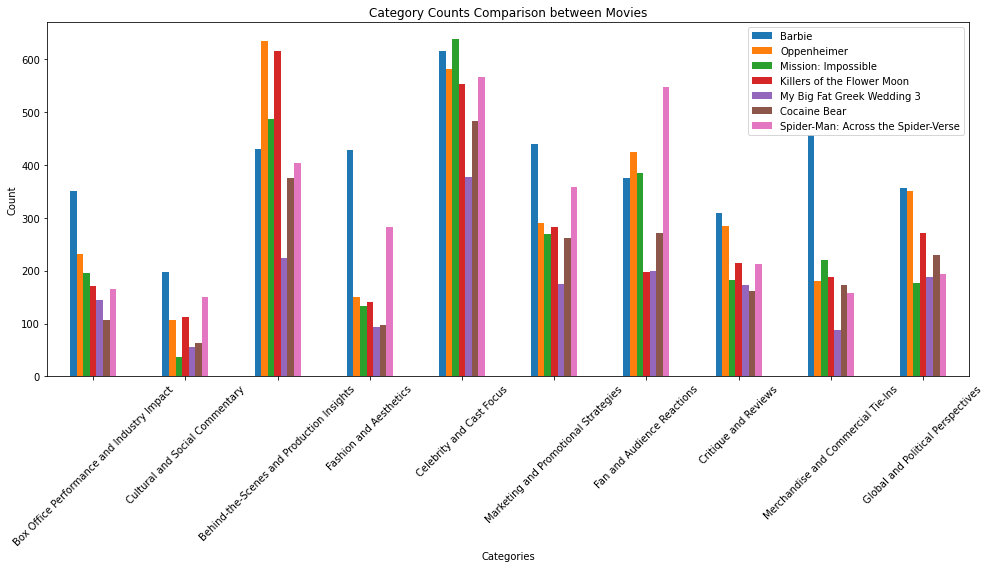

In [141]:
category_counts = [movie.df[list(categories)].sum() for movie in movies]
movie_titles = [movie.title for movie in movies]

# Create a DataFrame from the counts
data = dict(zip(movie_titles,category_counts))
df = pd.DataFrame(data)


ax = df.plot(kind='bar', figsize=(14, 8))

# Adding titles and labels using the ax object
ax.set_title('Category Counts Comparison between Movies')
ax.set_xlabel('Categories')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.pyplot.tight_layout()
plt.pyplot.savefig('category_counts.png',facecolor='white', transparent=False)

In [120]:
def get_percentage_box_office(movie, col_name):
    df = movie.df
    num_true = df[col_name].sum()
    total = df[col_name].count()
    return num_true/total

In [140]:
percentages_list = [[get_percentage_box_office(movie,cat) for movie in movies] for cat in categories]
gross_income = [movie.gross_income for movie in movies]
movie_names = [movie.title for movie in movies]

# Create and save each subplot as an individual figure
for i, percentages in enumerate(percentages_list):
    fig, ax = plt.pyplot.subplots(figsize=(10, 6))
    ax.scatter(gross_income, percentages)
    ax.set_title(f"Set {i + 1}: Percentage of Box Office Articles vs Movie Gross Income")
    ax.set_xlabel("Gross Income (in millions)")
    ax.set_ylabel("Percentage of Box Office Articles (%)")
    for j, name in enumerate(movie_names):
        ax.annotate(name, (gross_income[j], percentages[j]))
    
    # Save each figure
    plt.pyplot.savefig(f"yianni_imgs/{categories[i].replace(' ','_')}.png",facecolor='white', transparent=False)  # Change the path and filename as needed
    plt.pyplot.close(fig)  # Close the figure to free up memory

'Global_and_Political_Perspectives'

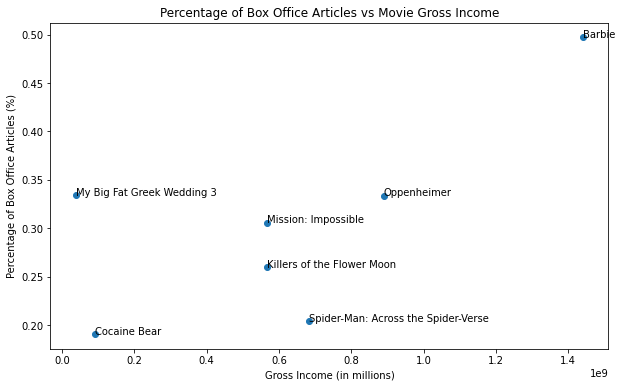

In [117]:
percentage_of_box_office_articles = [get_percentage_box_office(movie) for movie in movies]
gross_income = [movie.gross_income for movie in movies]
movie_names = [movie.title for movie in movies]

plt.pyplot.figure(figsize=(10, 6))
plt.pyplot.scatter(gross_income, percentage_of_box_office_articles)

# Adding labels and title
plt.pyplot.title("Percentage of Box Office Articles vs Movie Gross Income")
plt.pyplot.xlabel("Gross Income (in millions)")
plt.pyplot.ylabel("Percentage of Box Office Articles (%)")

# Annotating each point with the movie name
for i, name in enumerate(movie_names):
    plt.pyplot.annotate(name, (gross_income[i], percentage_of_box_office_articles[i]))

plt.pyplot.show()
